# Q2 Feature Mappings for Image Reconstruction 

## 2.1 Setup and Visualization

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import hashlib
import argparse
import pandas as pd
import glob
import time
import random
import time
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shutil
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Using SHA-256 to generate unique seed
username = "m.samartha"
seed = int( hashlib.sha256(username.encode()).hexdigest(),16) % (2**32)
print(seed)
np.random.seed(seed)

def add_username(username = "m.samartha") -> None:
    plt.text(0.95, 0.95, username, ha="right", va="top", transform=plt.gca().transAxes, fontsize=10, color="gray", alpha=0.7)

def add_username_fig(username = "m.samartha", fig=None) -> None:
    if fig is None:
        fig = plt.gcf()
    fig.text(
        0.97, 0.97, "m.samartha",
        ha='right', va='top',
        fontsize=10, color='gray', alpha=0.7
    )

2669878649


In [3]:
class ImageDataLoader:
    """
    Loads and preprocesses images for coordinate-based regression.

    Each image is mapped into:
        X → (2, N) array of pixel coordinates in [0, 1]
        Y → (C, N) array of target intensities in [0, 1]
    where C = 1 for grayscale, 3 for RGB.
    """

    def __init__(self, image_path, resize=(256, 256)):
        self.image_path = image_path
        self.resize = resize
        self.image, self.is_rgb = self.load_image()
        self.H, self.W = self.image.shape[:2]

    def load_image(self):
        """Open and normalize image to [0, 1]."""
        
        img = Image.open(self.image_path)
        if "smiley" in os.path.basename(self.image_path).lower():
            img = img.convert("L")
        img = img.resize(self.resize, Image.BICUBIC)

        # Convert to numpy in [0, 1]
        if img.mode == "L":   # grayscale
            arr = np.array(img, dtype=np.float32) / 255.0
            arr = arr[..., None]  # shape (H, W, 1)
            is_rgb = False
        else:  # RGB
            arr = np.array(img.convert("RGB"), dtype=np.float32) / 255.0
            is_rgb = True

        return arr, is_rgb

    def get_coordinates(self):
        """Return normalized 2D coordinate grid (H*W, 2)."""
        y, x = np.linspace(0, 1, self.H), np.linspace(0, 1, self.W)
        xv, yv = np.meshgrid(x, y)
        coords = np.stack([xv.flatten(), yv.flatten()], axis=0)
        return coords  # shape (2, N)

    def get_targets(self):
        """Return flattened pixel values (C, N)."""
        C = 3 if self.is_rgb else 1
        Y = self.image.reshape(-1, C).T
        return Y  # shape (C, N)

    def create_coordinate_grid(self, height, width):
        """
        Create normalized coordinate grid for image.
        
        Args:
            height: image height
            width: image width
            
        Returns:
            numpy array of shape (height*width, 2) with normalized (x, y) coordinates
        """
        x_coords = np.arange(width)
        y_coords = np.arange(height)
        xx, yy = np.meshgrid(x_coords, y_coords)
        
        coords = np.stack([xx.flatten(), yy.flatten()], axis=1)        
        return coords

    def visualize(self):
        """
        Show the loaded image and a random subset of coordinate samples.
        """
        plt.figure(figsize=(10, 4))

        plt.imshow(self.image.squeeze(), cmap="gray" if not self.is_rgb else None)
        plt.title(f"Original Image ({'RGB' if self.is_rgb else 'Grayscale'})")
        plt.axis("off")
        plt.tight_layout()
        plt.text(
            1, 1.05, "m.samartha",
            ha='right', va='top',
            transform=plt.gca().transAxes,
            fontsize=10, color='gray', alpha=0.7
        )
        plt.show()

Smiley shape: (256, 256, 1)


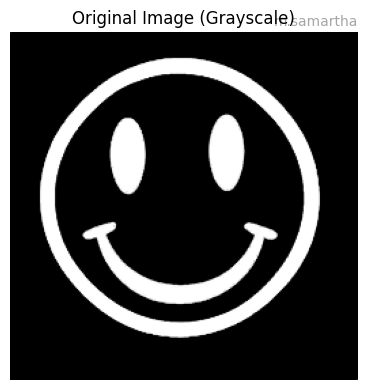

Cat shape: (256, 256, 3)


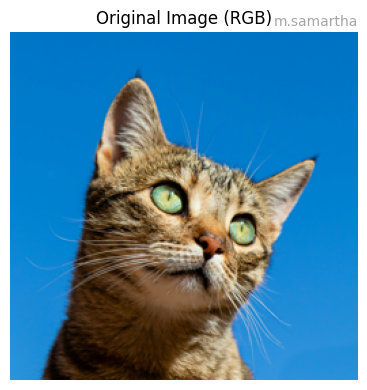

In [4]:
# Example 1: smiley.png (grayscale)
gray_loader = ImageDataLoader("Dataset/Q2/smiley.png")
smiley, _ = gray_loader.load_image()
print(f"Smiley shape: {smiley.shape}")
gray_loader.visualize()

# Example 2: cat.jpg (RGB)
rgb_loader = ImageDataLoader("Dataset/Q2/cat.jpg")
cat, _ = rgb_loader.load_image()
print(f"Cat shape: {cat.shape}")
rgb_loader.visualize()

## 2.2 Feature Expansions

In [5]:
def get_raw(coords):
    """
    Apply raw feature mapping to coordinates.
    
    Args:
        coords: numpy array of shape (N, 2) containing (x, y) coordinates
        
    Returns:
        numpy array of shape (N, 2) with raw coordinates as features
    """
    return coords


def get_polynomial(coords, order=5):
    """
    Apply polynomial (Taylor series) expansion to coordinates.
    
    Constructs polynomial basis up to specified order to approximate
    nonlinear variations in input coordinates.
    
    Args:
        coords: numpy array of shape (N, 2) containing (x, y) coordinates
        order: maximum degree of polynomial terms (default: 5)
        
    Returns:
        numpy array of shape (N, num_features) containing polynomial features
    """
    x = coords[:, 0]
    y = coords[:, 1]

    res = np.ones((coords.shape[0], 1))
    
    features = []
    for i in range(order + 1):
        for j in range(order + 1 - i):
            if i != 0 or j != 0:  # Skip the (0,0) term
                features = (x**i) * (y**j)
                res = np.hstack([res, features.reshape(-1, 1)])

    return res


def get_fourier(coords, freq=10):
    """
    Apply Fourier feature expansion to coordinates.
    
    Maps coordinates into sinusoidal embedding by computing sin/cos of
    different frequencies. Uses separate embeddings for x and y to avoid
    combinatorial explosion.
    
    Args:
        coords: numpy array of shape (N, 2) containing (x, y) coordinates
        freq: number of Fourier frequencies to use (default: 10)
        
    Returns:
        numpy array of shape (N, 4*freq) containing stacked Fourier features
    """
    x = coords[:, 0]
    y = coords[:, 1]
    
    features_x = []
    features_y = []
    
    for k in range(1, freq + 1):
        if k != 0:
            features_x.append(np.sin(2 * np.pi * k * x))
            features_x.append(np.cos(2 * np.pi * k * x))
            features_y.append(np.sin(2 * np.pi * k * y))
            features_y.append(np.cos(2 * np.pi * k * y))

    # Add a column of ones in the start
    res = np.ones((coords.shape[0], 1))
    
    # Concatenate features from x and y to this column of ones
    res = np.hstack([res, np.array(features_x).T, np.array(features_y).T])
    print(f"Shape of Fourier features: {res.shape}")
    
    return res

def create_coordinate_grid(height, width):
    """
    Create normalized coordinate grid for image.
    
    Args:
        height: image height
        width: image width
        
    Returns:
        numpy array of shape (height*width, 2) with normalized (x, y) coordinates
    """
    x_coords = np.arange(width)
    y_coords = np.arange(height)
    xx, yy = np.meshgrid(x_coords, y_coords)
    
    coords = np.stack([xx.flatten(), yy.flatten()], axis=1)    
    return coords

def load_image(image_path, image_type, target_size=256):
    """
    Load image from local file and optionally resize it.
    
    Args:
        image_path: path to local image file
        image_type: "Gray" for grayscale or "RGB" for color image
        target_size: target size for square image (default: 256)
        
    Returns:
        numpy array of image with shape (height, width) for grayscale
        or (height, width, 3) for RGB
    """
    img = Image.open(image_path)
    
    if image_type == "Gray":
        img = img.convert('L') # L is luminiscence - for grayscale values
    elif image_type == "RGB":
        img = img.convert('RGB')
    
    # Print current size of the image
    print(f"Original size of {image_path}: {img.size}")
    img = img.resize((target_size, target_size))
    
    return np.array(img)

#### Create Data to test

In [6]:
np.random.seed(seed)
sample_coords = np.random.rand(5, 2) * 2 - 1  # values between -1 and 1

print("--- Sample Input Coordinates ---")
print(sample_coords)
print(f"Shape: {sample_coords.shape}\n")

--- Sample Input Coordinates ---
[[-0.59987691 -0.5382126 ]
 [ 0.88761807  0.06354442]
 [-0.10880409 -0.99085218]
 [ 0.07143908 -0.67663046]
 [-0.22596276 -0.74211727]]
Shape: (5, 2)



#### 1) Raw mapping

In [7]:
print("--- 1. Raw Mapping ---")
raw_features = get_raw(sample_coords)
print(f"Output Dimension: {raw_features.shape[1]}")
print("Features:")
print(raw_features)
print(f"Shape: {raw_features.shape}\n")

--- 1. Raw Mapping ---
Output Dimension: 2
Features:
[[-0.59987691 -0.5382126 ]
 [ 0.88761807  0.06354442]
 [-0.10880409 -0.99085218]
 [ 0.07143908 -0.67663046]
 [-0.22596276 -0.74211727]]
Shape: (5, 2)



#### 2) Polynomial mapping

In [8]:
# 2. Polynomial Expansion
print("--- 2. Polynomial Expansion ---")
poly_features = get_polynomial(sample_coords, order=3)
print(f"Output Dimension: {poly_features.shape[1]}")
print("Features (1, x, y, xy, x^2, y^2, x^3, y^3, xy^2, x^2y):")
print(poly_features)
print(f"Shape: {poly_features.shape}\n")

--- 2. Polynomial Expansion ---
Output Dimension: 10
Features (1, x, y, xy, x^2, y^2, x^3, y^3, xy^2, x^2y):
[[ 1.00000000e+00 -5.38212603e-01  2.89672806e-01 -1.55905555e-01
  -5.99876910e-01  3.22861313e-01 -1.73768028e-01  3.59852308e-01
  -1.93677047e-01 -2.15867091e-01]
 [ 1.00000000e+00  6.35444168e-02  4.03789290e-03  2.56585550e-04
   8.87618068e-01  5.64031725e-02  3.58410670e-03  7.87865835e-01
   5.00644750e-02  6.99323950e-01]
 [ 1.00000000e+00 -9.90852180e-01  9.81788043e-01 -9.72806823e-01
  -1.08804087e-01  1.07808767e-01 -1.06822552e-01  1.18383295e-02
  -1.17300345e-02 -1.28805863e-03]
 [ 1.00000000e+00 -6.76630460e-01  4.57828780e-01 -3.09780898e-01
   7.14390775e-02 -4.83378559e-02  3.27068657e-02  5.10354179e-03
  -3.45321183e-03  3.64592317e-04]
 [ 1.00000000e+00 -7.42117269e-01  5.50738042e-01 -4.08712212e-01
  -2.25962764e-01  1.67690869e-01 -1.24446290e-01  5.10591706e-02
  -3.78918923e-02 -1.15374713e-02]]
Shape: (5, 10)



#### 3) Fourier Expansion

In [9]:
# 3. Fourier Expansion
print("--- 3. Fourier Expansion ---")
fourier_features = get_fourier(sample_coords, freq=4)
print(f"Output Dimension: {fourier_features.shape[1]}")
print("Features:")
print(fourier_features)
print(f"Shape: {fourier_features.shape}\n")

--- 3. Fourier Expansion ---
Shape of Fourier features: (5, 17)
Output Dimension: 17
Features:
[[ 1.          0.58715939 -0.80947134 -0.95057739  0.31048771  0.95177093
   0.30680954 -0.59028519 -0.80719477  0.23779671 -0.97131495 -0.461951
   0.88690545  0.65960311 -0.75161408 -0.81941372  0.57320254]
 [ 1.         -0.64888377  0.76088754 -0.98745515  0.15789971 -0.85380089
  -0.5205997  -0.31183777 -0.95013536  0.38873789  0.92134839  0.71632606
   0.6977657   0.93123383  0.36442223  0.99965551 -0.02624604]
 [ 1.         -0.6316163   0.77528114 -0.97936042  0.20212169 -0.88694301
  -0.46187887 -0.39589996 -0.91829365  0.0574458   0.99834863  0.11470188
   0.99339996  0.17157912  0.98517034  0.22788969  0.97368696]
 [ 1.          0.43394321  0.90094022  0.78191379  0.62338658  0.97497196
   0.22232786  0.97486912 -0.22277835  0.89561059 -0.44483893 -0.79680492
  -0.60423664 -0.18671088  0.98241491  0.96291746 -0.26979616]
 [ 1.         -0.98861657  0.15045689 -0.29748835 -0.95472545  

## 2.3 Normalization and Modular MLP 

In [10]:
def Modular_Dataloader(img_path, image_type, method, order=5, freq=10):
    """
    Load image and extract features using specified method with appropriate normalization.
    
    Args:
        img_path: path to the image (RGB or grayscale)
        image_type: either "RGB" or "Gray"
        method: feature mapping method ("Raw", "Polynomial", or "Fourier")
        order: order of polynomial expansion (default: 5, used only for Polynomial)
        freq: number of Fourier frequencies (default: 10, used only for Fourier)
        
    Returns:
        numpy array of shape (data_size, num_features) containing normalized features
    """
    
    # Load image
    img = load_image(img_path, image_type, target_size=256)
    
    # Create coordinate grid
    coords = create_coordinate_grid(img.shape[0], img.shape[1])
    height, width = img.shape[0], img.shape[1]
    
    if method == "Raw":
        features = get_raw(coords)
        # Normalize to [0, 1]
        features = features / np.array([width - 1, height - 1])
        
    elif method == "Polynomial":
        # Get polynomial features
        features = get_polynomial(coords, order=order)
        
        # Apply standard scaling
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
        
    elif method == "Fourier":
        # Normalize coordinates to [0, 1] for Fourier features
        coords = coords / np.array([width - 1, height - 1])
        features = get_fourier(coords, freq=freq)

    else:
        raise ValueError(f"Unknown method: {method}. Use 'Raw', 'Polynomial', or 'Fourier'.")
    
    return features

In [11]:
# Test the Modular_Dataloader
print("Testing Modular_Dataloader function...")

# Raw features
print("Raw features")
raw_features = Modular_Dataloader('Dataset/Q2/smiley.png', image_type='Gray', method="Raw")
print(f"Raw features shape: {raw_features.shape}")
print(f"Raw features min: {raw_features.min()}, max: {raw_features.max()}")
print(f"Expected range: [0, 1]")
print()

# Polynomial features
print("Polynomial features (order 5)")
poly_features = Modular_Dataloader('Dataset/Q2/smiley.png', image_type='Gray', method="Polynomial", order=5)
print(f"Polynomial features shape: {poly_features.shape}")
print(f"Polynomial features mean: {poly_features.mean():.6f}, std: {poly_features.std():.6f}")
print(f"Expected: mean ≈ 0, std ≈ 1 (standard scaled)")
print()

# Fourier features
print("Fourier features (freq 10)")
fourier_features = Modular_Dataloader('Dataset/Q2/smiley.png', image_type='Gray', method="Fourier", freq=10)
print(f"Fourier features shape: {fourier_features.shape}")
print(f"Fourier features min: {fourier_features.min():.6f}, max: {fourier_features.max():.6f}")
print(f"Expected range: approximately [-1, 1] (sine/cosine outputs)")
print()

# RGB image with Fourier
print("RGB image with Fourier features")
print(f"Original Cat shape: {cat.shape}")
fourier_cat = Modular_Dataloader('Dataset/Q2/cat.jpg', image_type='RGB', method="Fourier", freq=10)
print(f"Cat (RGB) Fourier features shape: {fourier_cat.shape}")
print()

Testing Modular_Dataloader function...
Raw features
Original size of Dataset/Q2/smiley.png: (256, 256)
Raw features shape: (65536, 2)
Raw features min: 0.0, max: 1.0
Expected range: [0, 1]

Polynomial features (order 5)
Original size of Dataset/Q2/smiley.png: (256, 256)
Polynomial features shape: (65536, 21)
Polynomial features mean: 0.000000, std: 0.975900
Expected: mean ≈ 0, std ≈ 1 (standard scaled)

Fourier features (freq 10)
Original size of Dataset/Q2/smiley.png: (256, 256)
Shape of Fourier features: (65536, 41)
Fourier features shape: (65536, 41)
Fourier features min: -0.999981, max: 1.000000
Expected range: approximately [-1, 1] (sine/cosine outputs)

RGB image with Fourier features
Original Cat shape: (256, 256, 3)
Original size of Dataset/Q2/cat.jpg: (2333, 2333)
Shape of Fourier features: (65536, 41)
Cat (RGB) Fourier features shape: (65536, 41)



## 2.4 Training and Comparison 

#### Activation Functions

In [12]:
class Activation:
    """This is an abstract base class or an "interface". 
    It serves as a blueprint for all other activation functions."""
    # Cannot be instantiated directly
    def forward(self, x):
        raise NotImplementedError

    def backward(self, grad_output):
        raise NotImplementedError

# Each of the following classes inherit from Activation and implement its methods
# During the forward pass, we store any necessary intermediate values
# During the backward pass, we use these stored values to compute gradients
class ReLU(Activation):
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        return grad_output * (self.x > 0)

class Tanh(Activation):
    def forward(self, x):
        self.out = np.tanh(x)
        return self.out

    def backward(self, grad_output):
        return grad_output * (1 - self.out ** 2)

class Sigmoid(Activation):
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, grad_output):
        return grad_output * self.out * (1 - self.out)

class Identity(Activation):
    def forward(self, x):
        return x

    def backward(self, grad_output):
        return grad_output

#### Linear class

In [13]:
class Linear:
    """
    Implements a fully connected layer with support for activation.
    Stores parameters, intermediate values, and accumulated gradients.
    """

    def __init__(self, in_features, out_features, activation=None):
        """in_features: input dimension
           out_features: output dimension
           activation: instance of Activation class (e.g., ReLU(), Sigmoid())
        """
        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation or Identity() # Default to Identity if no activation provided

        # Xavier initialization 
        limit = np.sqrt(6 / (in_features + out_features))
        self.weights = np.random.uniform(-limit, limit, (out_features, in_features))
        self.biases = np.zeros((out_features, 1))

        # Gradient accumulators
        self.grad_w = np.zeros_like(self.weights)
        self.grad_b = np.zeros_like(self.biases)

    def forward(self, x):
        """Forward pass through linear + activation."""
        self.input = x
        self.linear_output = np.dot(self.weights, x) + self.biases
        self.output = self.activation.forward(self.linear_output)
        return self.output
    
    def backward(self, grad_output):
        """Backward pass: compute gradients wrt weights, biases, and input."""
        grad_act = self.activation.backward(grad_output)

        # Gradients for weights and biases
        self.grad_w += np.dot(grad_act, self.input.T)
        self.grad_b += np.sum(grad_act, axis=1, keepdims=True)

        # Gradient wrt input (to pass to previous layer)
        grad_input = np.dot(self.weights.T, grad_act)
        return grad_input

    def zero_grad(self):
        """Reset accumulated gradients."""
        self.grad_w.fill(0)
        self.grad_b.fill(0)

    def update_params(self, lr):
        """Apply accumulated gradients and reset."""
        self.weights -= lr * self.grad_w
        self.biases -= lr * self.grad_b
        self.zero_grad()

#### Model Class

In [14]:
class Model:
    """
    Model that stacks multiple Linear layers and handles
    forward/backward passes, loss computation, and parameter updates.
    """

    def __init__(self, layers, loss_type="mse"):
        self.layers = layers
        if loss_type.lower() not in ["mse", "bce"]:
            raise ValueError("loss_type must be 'mse' or 'bce'")
        self.loss_type = loss_type.lower()

    def forward(self, x):
        """Run forward pass through all layers."""
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def compute_loss(self, y_pred, y_true):
        """Compute loss and gradient wrt output."""
        
        if self.loss_type == "mse":
            loss = np.mean((y_pred - y_true) ** 2)
            grad = 2 * (y_pred - y_true) / y_true.size

        elif self.loss_type == "bce":
            eps = 1e-8 # for numerical stability
            loss = -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))
            grad = (y_pred - y_true) / ((y_pred * (1 - y_pred) + eps) * y_true.size)
        return loss, grad

    def backward(self, grad_output):
        """Run backward pass through all layers (in reverse order)."""
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)

    def train_step(self, x, y):
        """Single forward+backward pass; accumulate gradients."""
        y_pred = self.forward(x)
        loss, grad_loss = self.compute_loss(y_pred, y)
        self.backward(grad_loss)
        return loss

    def zero_grad(self):
        """Reset all gradients."""
        for layer in self.layers:
            layer.zero_grad()

    def update(self, lr):
        """Update model parameters and reset grads."""
        for layer in self.layers:
            layer.update_params(lr)

    def predict(self, x):
        """Forward pass for inference."""
        return self.forward(x)

    def save_to(self, path):
        """Save all parameters to .npz file."""
        params = {}
        for i, layer in enumerate(self.layers):
            params[f"W{i}"] = layer.weights
            params[f"b{i}"] = layer.biases
        np.savez(path, **params)

    def load_from(self, path):
        """Load parameters from .npz file (check shapes)."""
        data = np.load(path)
        for i, layer in enumerate(self.layers):
            W, b = data[f"W{i}"], data[f"b{i}"]
            if W.shape != layer.weights.shape or b.shape != layer.biases.shape:
                raise ValueError(f"Shape mismatch in layer {i}")
            layer.weights, layer.biases = W, b

In [15]:
def create_map_model(input_dim=2, output_dim=1, loss_type = "bce"):
    """
    Dynamically creates a fully customizable Model instance with a specified architecture.
    """
    layers = [
        Linear(input_dim, 64, activation=Tanh()),
        Linear(64, 128, activation=Tanh()),
        Linear(128, 128, activation=ReLU()),
        Linear(128, output_dim, activation=Sigmoid())
    ]
    
    # Calculate params
    total_params = 0
    for layer in layers:
        total_params += layer.in_features * layer.out_features + layer.out_features
    print(f"Total parameters in the model: {total_params}")

    model = Model(layers, loss_type=loss_type)
    return model

#### Training Loop

In [16]:
def train_model(
    model,
    X,
    Y,
    dir,
    C = 1,
    epochs=50,
    batch_size=8192,
    lr=1,
    grad_accum_steps=1,
    early_stop_patience=10,
    relative_thresh=0.01,
    features = None,
    H = 256,
    W = 256
):
    """
    Train the model using mini-batch gradient descent with early stopping.

    Args:
        model: Model instance.
        X, Y: Training data (numpy arrays).
        epochs: Number of epochs.
        batch_size: Batch size.
        lr: Learning rate.
        grad_accum_steps: Steps before updating parameters.
        early_stop_patience: Number of epochs to check for early stopping.
        relative_thresh: 1% relative improvement threshold.
    """
    n_samples = X.shape[1]
    losses = []
    np.random.seed(42) # For reproducibility
    run_dir = dir
    os.makedirs(run_dir, exist_ok=True)
    # clear previous contents
    for f in os.listdir(run_dir):
        os.remove(os.path.join(run_dir, f))
    
    pbar = tqdm(range(epochs), desc="Training", unit="epoch")
    try:

        for epoch in range(epochs):
            perm = np.random.permutation(n_samples)
            X, Y = X[:, perm], Y[:, perm]
            epoch_loss = 0

            model.zero_grad()
            
            for i in range(0, n_samples, batch_size):
                batch_X = X[:, i:i + batch_size]
                batch_Y = Y[:, i:i + batch_size]

                loss = model.train_step(batch_X, batch_Y)
                epoch_loss += loss

                # Gradient accumulation
                if ((i // batch_size) + 1) % grad_accum_steps == 0:
                    model.update(lr)
                # pbar.set_postfix({"epoch": epoch + 1, "loss": f"{loss:.4f}"})
            
            num_batches = (n_samples + batch_size - 1) // batch_size
            avg_epoch_loss = epoch_loss / num_batches
            pbar.set_postfix({"loss": f"{avg_epoch_loss:.4f}"})
            pbar.update(1)

            losses.append(epoch_loss)
            
            # reconstructed = np.clip(model.predict(features), 0 , 1)
            reconstructed = model.predict(features).T
            # print(reconstructed.shape)
            if C == 1:
                reconstructed_img = reconstructed.reshape(256, 256)
                plt.imshow(reconstructed_img, cmap='gray', vmin=0, vmax=1)
            else:
                reconstructed_img = reconstructed.reshape(256, 256, 3)
                plt.imshow(reconstructed_img)
            plt.title(f'Reconstructed Image')
            plt.subplots_adjust(left=0.02, right=0.98, top=0.90, bottom=0.05)
            plt.axis('off')
            plt.savefig(f"{dir}/epoch_{epoch + 1}.png")
            plt.close() 
            
            # Early stopping
            if len(losses) > early_stop_patience:
                if losses[-1] >= (1-relative_thresh) * losses[-early_stop_patience]:
                    # print("Early stopping triggered.")
                    pbar.write(f"\nEarly stopping triggered at epoch {epoch + 1}") # Writes to console without breaking progress bar
                    # pbar.leave = False
                    break
    finally:
        pbar.close()
    
    # Final save
    if C == 1:
        reconstructed_img = reconstructed.reshape(256, 256)
        plt.imshow(reconstructed_img, cmap='gray', vmin=0, vmax=1)
    else:
        reconstructed_img = reconstructed.reshape(256, 256, 3)
        plt.imshow(reconstructed_img,vmin=0, vmax=1)
    plt.title(f'Reconstructed Image')
    plt.subplots_adjust(left=0.02, right=0.98, top=0.90, bottom=0.05)
    plt.axis('off')
    plt.savefig(f"{dir}/epoch_final.png")
    plt.close()

    # Plot training loss
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.subplots_adjust(top=0.90, bottom=0.05)
    plt.savefig(f"{run_dir}/loss_curve.png")
    plt.close()

    # Save model
    model.save_to(f"{run_dir}/model_params.npz")
    print(f"Training completed. Results saved in {run_dir}")

    return losses

### Smiley :)

#### 1) Raw mapping

In [17]:
smiley_image_path = "Dataset/Q2/smiley.png"
smiley_features_raw = Modular_Dataloader(smiley_image_path, method="Raw", image_type="Gray")
print(f"Raw features shape: {smiley_features_raw.shape}")

smiley_model_raw = create_map_model(input_dim=smiley_features_raw.shape[1], output_dim=1, loss_type="mse")

start_time = time.time()
raw_losses = train_model(
    model=smiley_model_raw,
    X=smiley_features_raw.T,
    Y=smiley.reshape(-1, 1).T,
    dir="Q2/2.4/smiley_raw",
    C=1,
    epochs=50,
    batch_size=8192,
    lr=5,
    grad_accum_steps=1,
    early_stop_patience=10,
    relative_thresh=0.01,
    features=smiley_features_raw.T
)
end_time = time.time()

print(f"Training time (Raw features): {end_time - start_time:.2f} seconds")

Original size of Dataset/Q2/smiley.png: (256, 256)
Raw features shape: (65536, 2)
Total parameters in the model: 25153


Training:  56%|█████▌    | 28/50 [00:26<00:21,  1.05epoch/s, loss=0.1323]


Early stopping triggered at epoch 28
Training completed. Results saved in Q2/2.4/smiley_raw
Training time (Raw features): 26.91 seconds


In [21]:
# save raw_losses
# convert list to numpy array
raw_losses_np = np.array(raw_losses)
np.savez("Q2/2.4/raw_losses.npz", raw_losses=raw_losses_np)

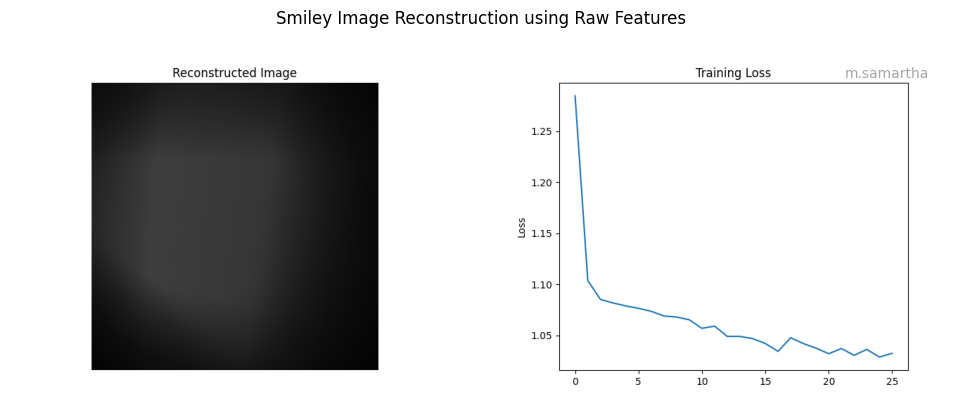

In [74]:
# Visualize final results
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
img = Image.open("Q2/2.4/smiley_raw/epoch_final.png")
loss_img = Image.open("Q2/2.4/smiley_raw/loss_curve.png")

# Reconstructed Image
axes[0].imshow(img)
axes[0].axis("off")

# Loss Curve
axes[1].imshow(loss_img, cmap="gray")
axes[1].axis("off")
fig.suptitle("Smiley Image Reconstruction using Raw Features")
plt.tight_layout()
add_username()
plt.show()

### 2) Polynomial mapping

In [26]:
smiley_image_path = "Dataset/Q2/smiley.png"
orders = [5, 15, 25]
poly_losses = {}
for order in orders:
    print(f"\nTraining with Polynomial features of order {order}")
    smiley_features_poly = Modular_Dataloader(smiley_image_path, method="Polynomial", order=order, image_type="Gray")
    print(f"Polynomial features shape: {smiley_features_poly.shape}")

    smiley_model_poly = create_map_model(input_dim=smiley_features_poly.shape[1], output_dim=1, loss_type="mse")

    start_time = time.time()
    poly_losses[order] = train_model(
        model=smiley_model_poly,
        X=smiley_features_poly.T,
        Y=smiley.reshape(-1, 1).T,
        dir="Q2/2.4/smiley_poly_" + str(order),
        C=1,
        epochs=50,
        batch_size=8192,
        lr=2,
        grad_accum_steps=1,
        early_stop_patience=10,
        relative_thresh=0.01,
        features=smiley_features_poly.T 
    )
    end_time = time.time()

    print(f"Training time: {end_time - start_time:.2f} seconds")


Training with Polynomial features of order 5
Original size of Dataset/Q2/smiley.png: (256, 256)
Polynomial features shape: (65536, 21)
Total parameters in the model: 26369


Training:  82%|████████▏ | 41/50 [00:39<00:08,  1.05epoch/s, loss=0.1054]



Early stopping triggered at epoch 41
Training completed. Results saved in Q2/2.4/smiley_poly_5
Training time: 39.25 seconds

Training with Polynomial features of order 15
Original size of Dataset/Q2/smiley.png: (256, 256)
Polynomial features shape: (65536, 136)
Total parameters in the model: 33729


Training: 100%|██████████| 50/50 [00:56<00:00,  1.12s/epoch, loss=0.0974]


Training completed. Results saved in Q2/2.4/smiley_poly_15
Training time: 56.34 seconds

Training with Polynomial features of order 25
Original size of Dataset/Q2/smiley.png: (256, 256)
Polynomial features shape: (65536, 351)
Total parameters in the model: 47489


Training: 100%|██████████| 50/50 [00:57<00:00,  1.15s/epoch, loss=0.0955]

Training completed. Results saved in Q2/2.4/smiley_poly_25
Training time: 57.54 seconds


In [27]:
# save poly_losses
poly_losses_np = {str(k): np.array(v) for k, v in poly_losses.items()}
np.savez("Q2/2.4/poly_losses.npz", **poly_losses_np)

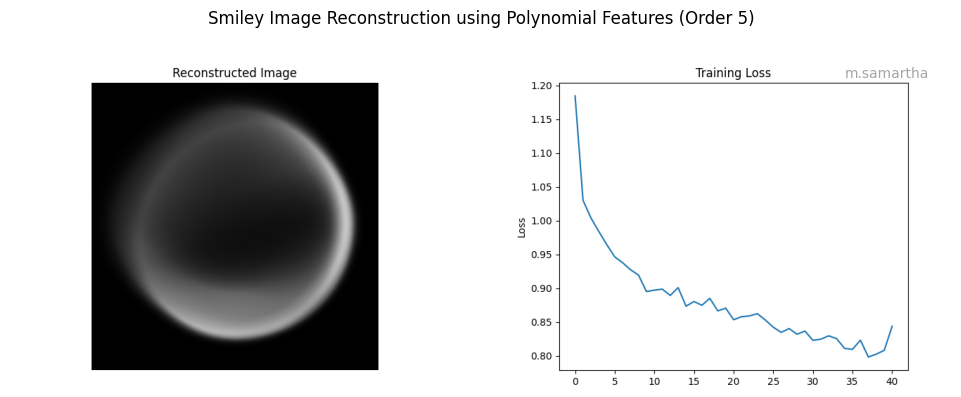

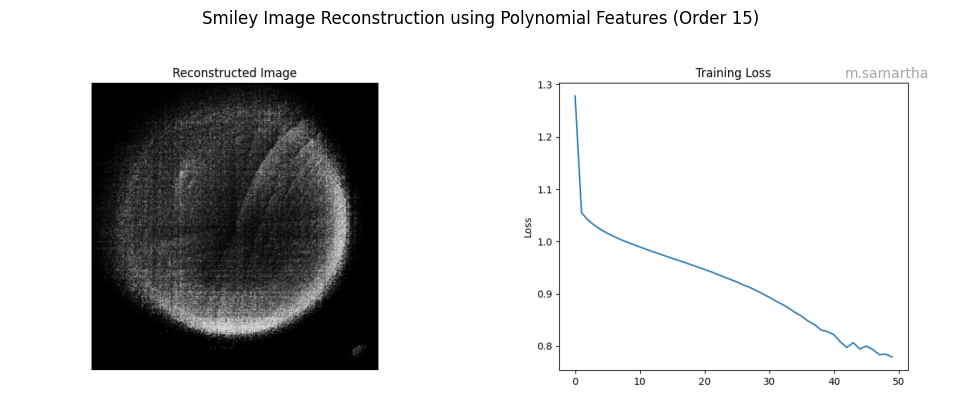

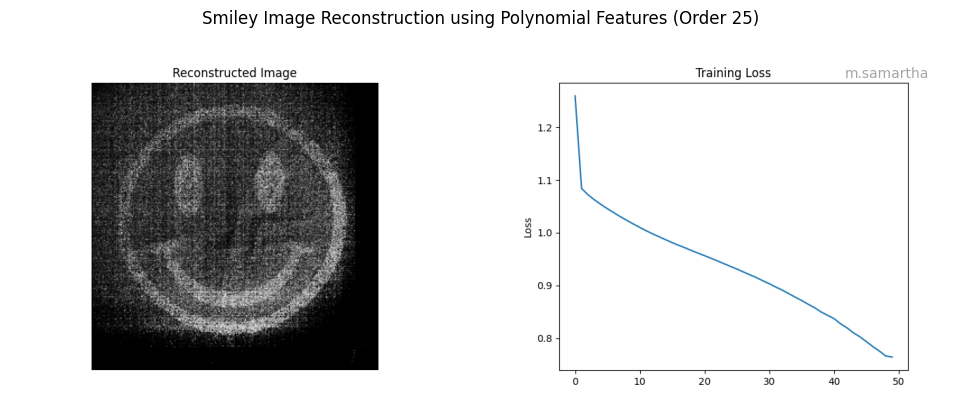

In [28]:
# Visualize results for smiley with different polynomial orders
orders = [5, 15, 25]

for i, order in enumerate(orders):  
    img = Image.open(f"Q2/2.4/smiley_poly_{order}/epoch_final.png")
    loss_img = Image.open(f"Q2/2.4/smiley_poly_{order}/loss_curve.png")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Reconstructed Image
    axes[0].imshow(img)
    axes[0].axis("off")

    # Loss Curve
    axes[1].imshow(loss_img, cmap="gray")
    axes[1].axis("off")
    fig.suptitle(f"Smiley Image Reconstruction using Polynomial Features (Order {order})")
    fig.tight_layout()
    add_username()
    plt.show()

### 3) Fourier Expansion

In [29]:
smiley_image_path = "Dataset/Q2/smiley.png"
freqs = [5, 15, 25]
fourier_losses = {}
for freq in freqs:
    print(f"\nTraining with Fourier features of frequency {freq}")
    smiley_features_fourier = Modular_Dataloader(smiley_image_path, method="Fourier", freq=freq, image_type="Gray")
    print(f"Fourier features shape: {smiley_features_fourier.shape}")

    smiley_model_fourier = create_map_model(input_dim=smiley_features_fourier.shape[1], output_dim=1, loss_type="mse")

    start_time = time.time()
    fourier_losses[freq] = train_model(
        model=smiley_model_fourier,
        X=smiley_features_fourier.T,
        Y=smiley.reshape(-1, 1).T,
        dir="Q2/2.4/smiley_fourier_" + str(freq),
        C=1,
        epochs=50,
        batch_size=8192,
        lr=4,
        grad_accum_steps=1,
        early_stop_patience=10,
        relative_thresh=0.01,
        features=smiley_features_fourier.T 
    )
    end_time = time.time()

    print(f"Training time: {end_time - start_time:.2f} seconds")


Training with Fourier features of frequency 5
Original size of Dataset/Q2/smiley.png: (256, 256)
Shape of Fourier features: (65536, 21)
Fourier features shape: (65536, 21)
Total parameters in the model: 26369


Training:  80%|████████  | 40/50 [00:30<00:07,  1.33epoch/s, loss=0.0162]



Early stopping triggered at epoch 40
Training completed. Results saved in Q2/2.4/smiley_fourier_5
Training time: 30.26 seconds

Training with Fourier features of frequency 15
Original size of Dataset/Q2/smiley.png: (256, 256)
Shape of Fourier features: (65536, 61)
Fourier features shape: (65536, 61)
Total parameters in the model: 28929


Training:  70%|███████   | 35/50 [00:30<00:13,  1.14epoch/s, loss=0.0047]



Early stopping triggered at epoch 35
Training completed. Results saved in Q2/2.4/smiley_fourier_15
Training time: 30.78 seconds

Training with Fourier features of frequency 25
Original size of Dataset/Q2/smiley.png: (256, 256)
Shape of Fourier features: (65536, 101)
Fourier features shape: (65536, 101)
Total parameters in the model: 31489


Training: 100%|██████████| 50/50 [00:43<00:00,  1.15epoch/s, loss=0.0016]


Early stopping triggered at epoch 50
Training completed. Results saved in Q2/2.4/smiley_fourier_25
Training time: 43.66 seconds


In [30]:
# save fourier_losses
fourier_losses_np = {str(k): np.array(v) for k, v in fourier_losses.items()}
np.savez("Q2/2.4/fourier_losses.npz", **fourier_losses_np)

<Figure size 1500x500 with 0 Axes>

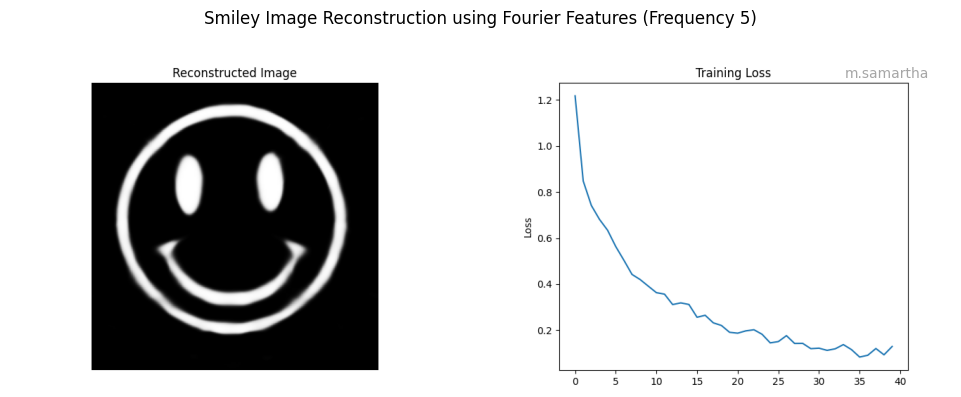

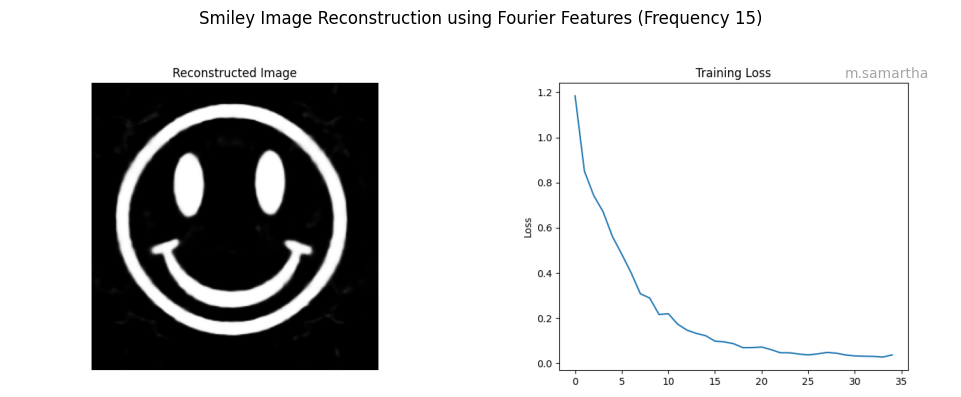

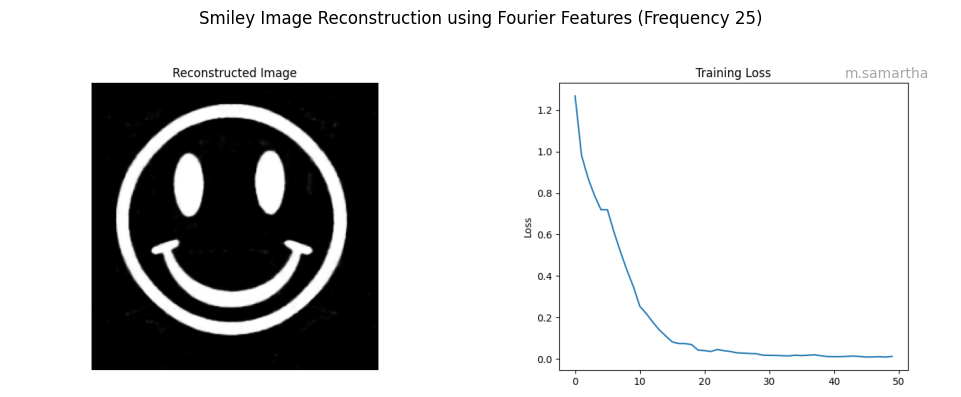

In [31]:
# Visualize results for smiley with different frequencies
freqs = [5, 15, 25]
plt.figure(figsize=(15, 5))
for i, freq in enumerate(freqs):  
    img = Image.open(f"Q2/2.4/smiley_fourier_{freq}/epoch_final.png")
    loss_img = Image.open(f"Q2/2.4/smiley_fourier_{freq}/loss_curve.png")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Reconstructed Image
    axes[0].imshow(img)
    axes[0].axis("off")

    # Loss Curve
    axes[1].imshow(loss_img, cmap="gray")
    axes[1].axis("off")
    fig.suptitle(f"Smiley Image Reconstruction using Fourier Features (Frequency {freq})")
    plt.tight_layout()
    add_username()
    plt.show()

### Cat ^_^

#### 1) Raw mapping

In [32]:
cat_image_path = "Dataset/Q2/cat.jpg"
cat_features_raw = Modular_Dataloader(cat_image_path, method="Raw", image_type="RGB")

# For RGB, we need to handle all 3 channels
target_pixels = cat.reshape(-1, 3) 
print(f"Raw features shape: {cat_features_raw.shape}")
print(f"Target pixels shape: {target_pixels.shape}")

cat_model_raw = create_map_model(input_dim=cat_features_raw.shape[1], output_dim=3, loss_type="mse")

start_time = time.time()
cat_raw_losses = train_model(
    model=cat_model_raw,
    X=cat_features_raw.T,
    Y=target_pixels.T,
    dir="Q2/2.4/cat_raw",
    C=3,
    epochs=150,
    batch_size=8192,
    lr=1,
    grad_accum_steps=1,
    early_stop_patience=10,
    relative_thresh=0.01,
    features=cat_features_raw.T
)
end_time = time.time()

print(f"Training time (Raw features): {end_time - start_time:.2f} seconds")

Original size of Dataset/Q2/cat.jpg: (2333, 2333)
Raw features shape: (65536, 2)
Target pixels shape: (65536, 3)
Total parameters in the model: 25411


Training: 100%|██████████| 150/150 [02:00<00:00,  1.24epoch/s, loss=0.0208]

Training completed. Results saved in Q2/2.4/cat_raw
Training time (Raw features): 120.68 seconds


In [33]:
# save cat_raw_losses
cat_raw_losses_np = np.array(cat_raw_losses)
np.savez("Q2/2.4/cat_raw_losses.npz", cat_raw_losses=cat_raw_losses_np)

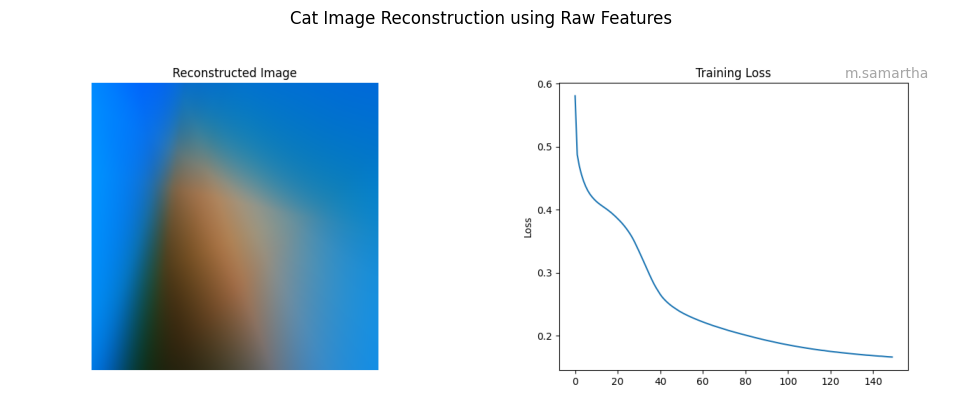

In [34]:
# Visualize final results
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
img = Image.open("Q2/2.4/cat_raw/epoch_final.png")
loss_img = Image.open("Q2/2.4/cat_raw/loss_curve.png")

# Reconstructed Image
axes[0].imshow(img)
axes[0].axis("off")

# Loss Curve
axes[1].imshow(loss_img, cmap="gray")
axes[1].axis("off")
fig.suptitle("Cat Image Reconstruction using Raw Features")
plt.tight_layout()
add_username()
plt.show()

#### 2) Polynomial mapping

In [35]:
cat_image_path = "Dataset/Q2/cat.jpg"
orders = [5, 15, 25]
target_pixels = cat.reshape(-1, 3)

cat_poly_losses = {}
for order in orders:
    print(f"\nTraining with Polynomial features of order {order}")
    cat_features_poly = Modular_Dataloader(cat_image_path, method="Polynomial", order=order, image_type="RGB")
    print(f"Polynomial features shape: {cat_features_poly.shape}")

    cat_model_poly = create_map_model(input_dim=cat_features_poly.shape[1], output_dim=3, loss_type="mse")

    start_time = time.time()
    cat_poly_losses[order] = train_model(
        model=cat_model_poly,
        X=cat_features_poly.T,
        Y=target_pixels.T,
        dir="Q2/2.4/cat_poly_" + str(order),
        C=3,
        epochs=150,
        batch_size=8192,
        lr=2,
        grad_accum_steps=1,
        early_stop_patience=10,
        relative_thresh=0.01,
        features=cat_features_poly.T 
    )
    end_time = time.time()

    print(f"Training time: {end_time - start_time:.2f} seconds")


Training with Polynomial features of order 5
Original size of Dataset/Q2/cat.jpg: (2333, 2333)
Polynomial features shape: (65536, 21)
Total parameters in the model: 26627


Training:  28%|██▊       | 42/150 [00:32<01:24,  1.28epoch/s, loss=0.0178]



Early stopping triggered at epoch 42
Training completed. Results saved in Q2/2.4/cat_poly_5
Training time: 32.93 seconds

Training with Polynomial features of order 15
Original size of Dataset/Q2/cat.jpg: (2333, 2333)
Polynomial features shape: (65536, 136)
Total parameters in the model: 33987


Training:  82%|████████▏ | 123/150 [01:52<00:24,  1.09epoch/s, loss=0.0154]



Early stopping triggered at epoch 123
Training completed. Results saved in Q2/2.4/cat_poly_15
Training time: 112.56 seconds

Training with Polynomial features of order 25
Original size of Dataset/Q2/cat.jpg: (2333, 2333)
Polynomial features shape: (65536, 351)
Total parameters in the model: 47747


Training: 100%|██████████| 150/150 [02:54<00:00,  1.17s/epoch, loss=0.0149]

Training completed. Results saved in Q2/2.4/cat_poly_25
Training time: 175.03 seconds


In [36]:
# save cat_poly_losses
cat_poly_losses_np = {str(k): np.array(v) for k, v in cat_poly_losses.items()}
np.savez("Q2/2.4/cat_poly_losses.npz", **cat_poly_losses_np)

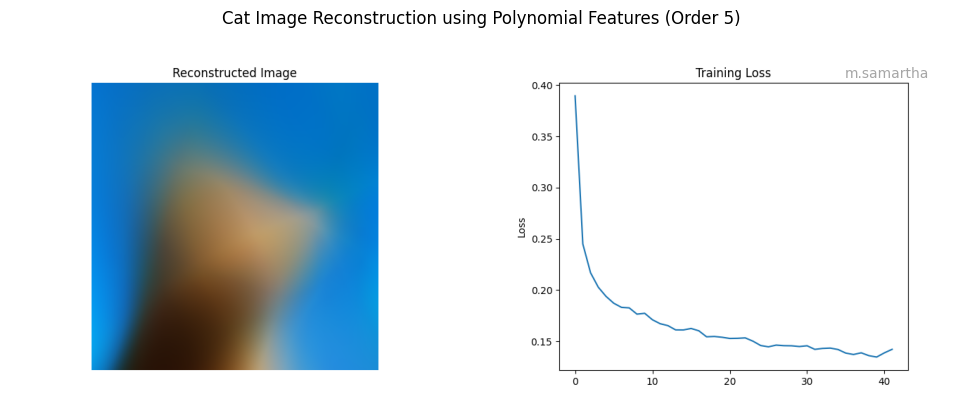

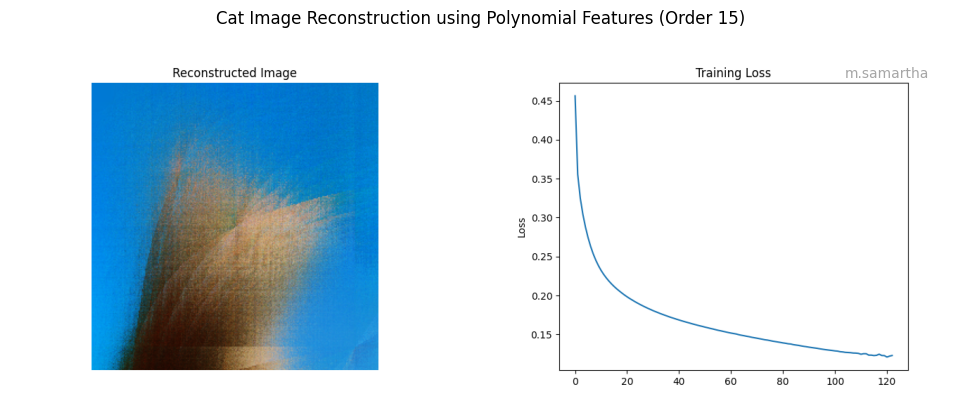

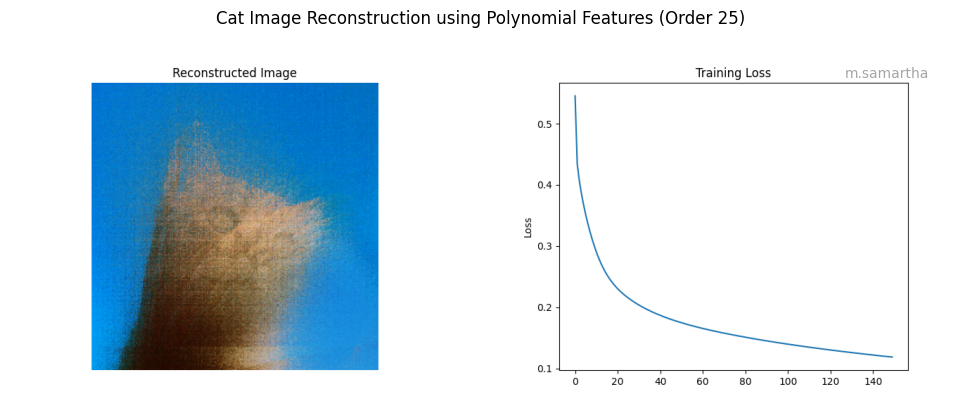

In [37]:
# Visualize results for smiley with different polynomial orders
orders = [5, 15, 25]

for i, order in enumerate(orders):  
    img = Image.open(f"Q2/2.4/cat_poly_{order}/epoch_final.png")
    loss_img = Image.open(f"Q2/2.4/cat_poly_{order}/loss_curve.png")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Reconstructed Image
    axes[0].imshow(img)
    axes[0].axis("off")

    # Loss Curve
    axes[1].imshow(loss_img, cmap="gray")
    axes[1].axis("off")
    fig.suptitle(f"Cat Image Reconstruction using Polynomial Features (Order {order})")
    fig.tight_layout()
    add_username()
    plt.show()

#### 3) Fourier Expansion

In [38]:
cat_image_path = "Dataset/Q2/cat.jpg"
freqs = [5, 15, 25]
cat_fourier_losses = {}
target_pixels = cat.reshape(-1, 3)

for freq in freqs:
    print(f"\nTraining with Fourier features of frequency {freq}")
    cat_features_fourier = Modular_Dataloader(cat_image_path, method="Fourier", freq=freq, image_type="RGB")
    print(f"Fourier features shape: {cat_features_fourier.shape}")
    
    cat_model_fourier = create_map_model(input_dim=cat_features_fourier.shape[1], output_dim=3, loss_type="mse")

    start_time = time.time()
    cat_fourier_losses[freq] = train_model(
        model=cat_model_fourier,
        X=cat_features_fourier.T,
        Y=target_pixels.T,
        dir="Q2/2.4/cat_fourier_" + str(freq),
        C=3,
        epochs=150,
        batch_size=8192,
        lr=4,
        grad_accum_steps=1,
        early_stop_patience=10,
        relative_thresh=0.01,
        features=cat_features_fourier.T
    )
    end_time = time.time()

    print(f"Training time: {end_time - start_time:.2f} seconds")


Training with Fourier features of frequency 5
Original size of Dataset/Q2/cat.jpg: (2333, 2333)
Shape of Fourier features: (65536, 21)
Fourier features shape: (65536, 21)
Total parameters in the model: 26627


Training:  33%|███▎      | 49/150 [00:39<01:21,  1.23epoch/s, loss=0.0096]



Early stopping triggered at epoch 49
Training completed. Results saved in Q2/2.4/cat_fourier_5
Training time: 39.86 seconds

Training with Fourier features of frequency 15
Original size of Dataset/Q2/cat.jpg: (2333, 2333)
Shape of Fourier features: (65536, 61)
Fourier features shape: (65536, 61)
Total parameters in the model: 29187


Training:  29%|██▉       | 44/150 [00:40<01:36,  1.09epoch/s, loss=0.0075]



Early stopping triggered at epoch 44
Training completed. Results saved in Q2/2.4/cat_fourier_15
Training time: 40.42 seconds

Training with Fourier features of frequency 25
Original size of Dataset/Q2/cat.jpg: (2333, 2333)
Shape of Fourier features: (65536, 101)
Fourier features shape: (65536, 101)
Total parameters in the model: 31747


Training:  55%|█████▍    | 82/150 [01:06<00:55,  1.24epoch/s, loss=0.0058]


Early stopping triggered at epoch 82
Training completed. Results saved in Q2/2.4/cat_fourier_25
Training time: 66.53 seconds


In [39]:
# save cat_fourier_losses
cat_fourier_losses_np = {str(k): np.array(v) for k, v in cat_fourier_losses.items()}
np.savez("Q2/2.4/cat_fourier_losses.npz", **cat_fourier_losses_np)

<Figure size 1500x500 with 0 Axes>

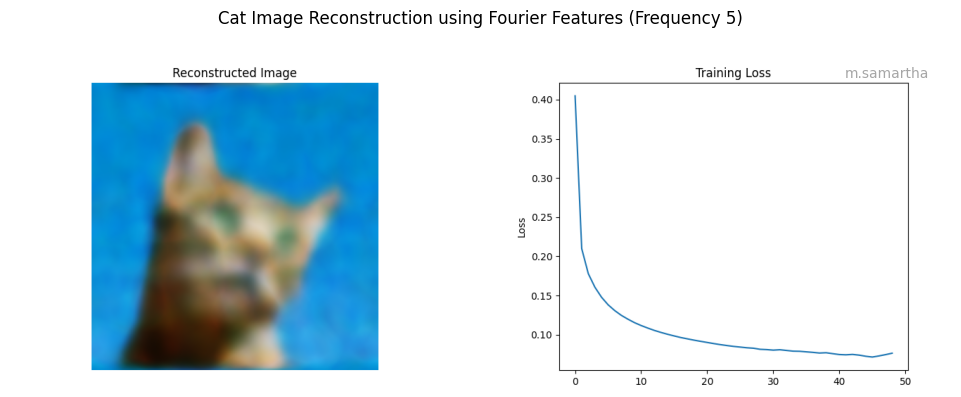

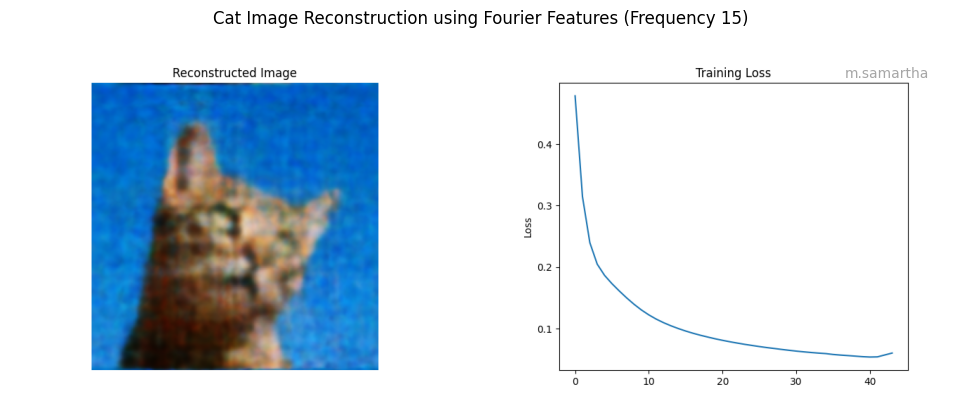

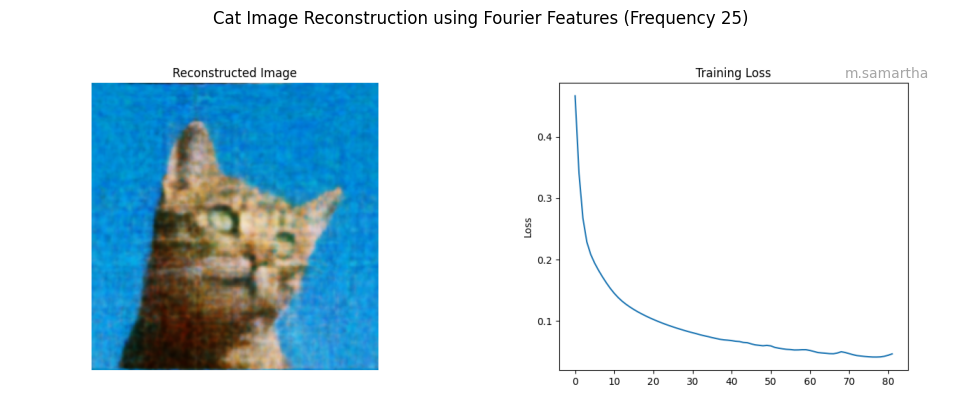

In [40]:
# Visualize results for smiley with different polynomial orders
freqs = [5, 15, 25]
plt.figure(figsize=(15, 5))
for i, freq in enumerate(freqs):  
    img = Image.open(f"Q2/2.4/cat_fourier_{freq}/epoch_final.png")
    loss_img = Image.open(f"Q2/2.4/cat_fourier_{freq}/loss_curve.png")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Reconstructed Image
    axes[0].imshow(img)
    axes[0].axis("off")

    # Loss Curve
    axes[1].imshow(loss_img, cmap="gray")
    axes[1].axis("off")
    fig.suptitle(f"Cat Image Reconstruction using Fourier Features (Frequency {freq})")
    plt.tight_layout()
    add_username()
    plt.show()

### GIF Visualization

In [5]:
def create_GIF(str, raw_losses_selected, poly_losses_selected, fourier_losses_selected, 
               raw_img_folder, poly_img_folder, fourier_img_folder):
    # --- 1. Determine Max Epochs ---
    max_epochs = max(len(raw_losses_selected), len(poly_losses_selected), len(fourier_losses_selected))

    # --- 2. Create a list to store frames for the GIF ---
    gif_frames = []

    # --- 3. Loop through epochs to create each frame ---
    for epoch in range(max_epochs):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # Adjust figsize as needed
        epoch = epoch+1
        # --- Process Raw Method ---
        if epoch < len(raw_losses_selected):
            raw_img_path = os.path.join(raw_img_folder, f"epoch_{epoch}.png") # Adjust filename pattern
            raw_img = mpimg.imread(raw_img_path)
            axes[0].imshow(raw_img)
            axes[0].set_title("Raw Features")
            # Plot loss curve as legend (example: last 10 losses or full curve up to current epoch)
            ax_inset = inset_axes(axes[0], width="30%", height="30%", loc='upper left')
            ax_inset.plot(range(epoch + 1), raw_losses_selected[:epoch + 1], color='red')
            ax_inset.tick_params(axis='both', colors='red')
        else:
            # Freeze the last available raw image
            last_raw_img_path = os.path.join(raw_img_folder, f"epoch_{len(raw_losses_selected)}.png")
            last_raw_img = mpimg.imread(last_raw_img_path)
            axes[0].imshow(last_raw_img)
            axes[0].set_title("Raw Features (Frozen)")
            ax_inset = inset_axes(axes[0], width="30%", height="30%", loc='upper left')
            ax_inset.plot(range(len(raw_losses_selected)), raw_losses_selected, color='red')
            ax_inset.tick_params(axis='both', colors='red')


        # --- Process Polynomial Method ---
        if epoch < len(poly_losses_selected):
            poly_img_path = os.path.join(poly_img_folder, f"epoch_{epoch}.png")
            poly_img = mpimg.imread(poly_img_path)
            axes[1].imshow(poly_img)
            axes[1].set_title("Polynomial Features")
            # FIX: Use the new list for plotting
            ax_inset = inset_axes(axes[1], width="30%", height="30%", loc='upper left')
            ax_inset.plot(range(epoch + 1), poly_losses_selected[:epoch + 1], color='blue')
            ax_inset.tick_params(axis='both', colors='red')
        else:
            # Freeze the last available polynomial image
            last_poly_img_path = os.path.join(poly_img_folder, f"epoch_{len(poly_losses_selected)}.png")
            last_poly_img = mpimg.imread(last_poly_img_path)
            axes[1].imshow(last_poly_img)
            axes[1].set_title("Polynomial Features (Frozen)")
            # FIX: Use the new list for plotting
            ax_inset = inset_axes(axes[1], width="30%", height="30%", loc='upper left')
            ax_inset.plot(range(len(poly_losses_selected)), poly_losses_selected, color='blue')
            ax_inset.tick_params(axis='both', colors='red')


        # --- Process Fourier Method ---
        if epoch < len(fourier_losses_selected):
            fourier_img_path = os.path.join(fourier_img_folder, f"epoch_{epoch}.png") # Adjust filename pattern
            fourier_img = mpimg.imread(fourier_img_path)
            axes[2].imshow(fourier_img)
            axes[2].set_title("Fourier Features")
            ax_inset = inset_axes(axes[2], width="30%", height="30%", loc='upper left')
            ax_inset.plot(range(epoch + 1), fourier_losses_selected[:epoch + 1], color='green')
            ax_inset.tick_params(axis='both', colors='red')
        else:
            # Freeze the last available fourier image
            last_fourier_img_path = os.path.join(fourier_img_folder, f"epoch_{len(fourier_losses_selected)}.png")
            last_fourier_img = mpimg.imread(last_fourier_img_path)
            axes[2].imshow(last_fourier_img)
            axes[2].set_title("Fourier Features (Frozen)")
            ax_inset = inset_axes(axes[2], width="30%", height="30%", loc='upper left')
            ax_inset.plot(range(len(fourier_losses_selected)), fourier_losses_selected, color='green')
            ax_inset.tick_params(axis='both', colors='red')

        # Hide axes ticks for cleaner image display
        for ax in axes:
            ax.axis('off')

        plt.tight_layout()
        fig.text(0.95, 0.95, username, ha="right", va="top", fontsize=10, color="gray", alpha=0.7)

        # Save the current figure to a temporary buffer or file
        # This is a common way to convert a matplotlib figure to a PIL Image
        # create temp directory if it doesn't exist
        if not os.path.exists("Q2/2.4/Temp"):
            os.makedirs("Q2/2.4/Temp")
        plt.savefig(f"Q2/2.4/Temp/temp_frame_epoch_{epoch}.png")
        gif_frames.append(Image.open(f"Q2/2.4/Temp/temp_frame_epoch_{epoch}.png"))
        plt.close(fig) # Close the figure to free memory

    # --- 4. Save the GIF ---
    if gif_frames:
        gif_frames[0].save(
            f'Q2/2.4/animation_{str}.gif',
            format='GIF',
            append_images=gif_frames[1:],
            save_all=True,
            duration=200,  # Milliseconds per frame
            loop=0         # 0 means loop forever
        )
        shutil.rmtree("Q2/2.4/Temp")  # Clean up temp directory and all its files

    print(f"GIF created successfully: Q2/2.4/animation_{str}.gif")

# 1. Smiley Image
raw_losses = np.load("Q2/2.4/raw_losses.npz")['raw_losses']
poly_losses = np.load("Q2/2.4/poly_losses.npz")
fourier_losses = np.load("Q2/2.4/fourier_losses.npz")

raw_losses_selected = raw_losses
poly_losses_selected = poly_losses['25']  # Using order 25 for polynomial
fourier_losses_selected = fourier_losses['25']  # Using frequency 25 for Fourier

raw_img_folder = "Q2/2.4/smiley_raw"
poly_img_folder = "Q2/2.4/smiley_poly_25"
fourier_img_folder = "Q2/2.4/smiley_fourier_25"

create_GIF("smiley", raw_losses_selected, poly_losses_selected, fourier_losses_selected, 
           raw_img_folder, poly_img_folder, fourier_img_folder)

GIF created successfully: Q2/2.4/animation_smiley.gif


In [6]:
# 2. Cat Image
cat_raw_losses = np.load("Q2/2.4/cat_raw_losses.npz")['cat_raw_losses']
cat_poly_losses = np.load("Q2/2.4/cat_poly_losses.npz")
cat_fourier_losses = np.load("Q2/2.4/cat_fourier_losses.npz")

raw_losses_selected = cat_raw_losses
poly_losses_selected = cat_poly_losses['25']  # Using order 25 for polynomial
fourier_losses_selected = cat_fourier_losses['25']  # Using frequency 25 for Fourier

raw_img_folder = "Q2/2.4/cat_raw"
poly_img_folder = "Q2/2.4/cat_poly_25"
fourier_img_folder = "Q2/2.4/cat_fourier_25"

create_GIF("cat", raw_losses_selected, poly_losses_selected, fourier_losses_selected, 
           raw_img_folder, poly_img_folder, fourier_img_folder)

GIF created successfully: Q2/2.4/animation_cat.gif


## 2.5 Reconstruction on Blurred Images 

### 1) Raw Mapping

In [ ]:
num_blur = 10
blurred_cat_raw_losses = {}
print("\n--- Training on Blurred Cat Images with Raw Features ---")

for i in range(num_blur):
    print(f"\nTraining on blurred image {i+1}/{num_blur}")
    cat_image_path = os.path.join("Dataset/Q2/blurred", f"blur_{i}.png")
    cat_features_raw = Modular_Dataloader(cat_image_path, method="Raw", image_type="RGB")

    # For RGB, we need to handle all 3 channels
    target_pixels = cat.reshape(-1, 3) 
    print(f"Raw features shape: {cat_features_raw.shape}")
    print(f"Target pixels shape: {target_pixels.shape}")

    cat_model_raw = create_map_model(input_dim=cat_features_raw.shape[1], output_dim=3, loss_type="mse")

    start_time = time.time()
    blurred_cat_raw_losses[i] = train_model(
        model=cat_model_raw,
        X=cat_features_raw.T,
        Y=target_pixels.T,
        dir="Q2/2.5/cat_raw/blur_" + str(i),
        C=3,
        epochs=100,
        batch_size=8192,
        lr=1,
        grad_accum_steps=1,
        early_stop_patience=10,
        relative_thresh=0.01,
        features=cat_features_raw.T
    )
    end_time = time.time()

    print(f"Training time (Raw features): {end_time - start_time:.2f} seconds")



--- Training on Blurred Cat Images with Raw Features ---

Training on blurred image 1/10
Original size of Dataset/Q2/blurred/blur_0.png: (256, 256)
Raw features shape: (65536, 2)
Target pixels shape: (65536, 3)
Total parameters in the model: 25411


Training: 100%|██████████| 100/100 [01:30<00:00,  1.10epoch/s, loss=0.0240]


Training completed. Results saved in Q2/2.5/cat_raw/blur_0
Training time (Raw features): 90.89 seconds

Training on blurred image 2/10
Original size of Dataset/Q2/blurred/blur_1.png: (256, 256)
Raw features shape: (65536, 2)
Target pixels shape: (65536, 3)
Total parameters in the model: 25411


Training: 100%|██████████| 100/100 [01:39<00:00,  1.00epoch/s, loss=0.0233]


Training completed. Results saved in Q2/2.5/cat_raw/blur_1
Training time (Raw features): 99.67 seconds

Training on blurred image 3/10
Original size of Dataset/Q2/blurred/blur_2.png: (256, 256)
Raw features shape: (65536, 2)
Target pixels shape: (65536, 3)
Total parameters in the model: 25411


Training: 100%|██████████| 100/100 [01:35<00:00,  1.04epoch/s, loss=0.0233]


Training completed. Results saved in Q2/2.5/cat_raw/blur_2
Training time (Raw features): 96.23 seconds

Training on blurred image 4/10
Original size of Dataset/Q2/blurred/blur_3.png: (256, 256)
Raw features shape: (65536, 2)
Target pixels shape: (65536, 3)
Total parameters in the model: 25411


Training: 100%|██████████| 100/100 [01:31<00:00,  1.09epoch/s, loss=0.0233]


Training completed. Results saved in Q2/2.5/cat_raw/blur_3
Training time (Raw features): 91.55 seconds

Training on blurred image 5/10
Original size of Dataset/Q2/blurred/blur_4.png: (256, 256)
Raw features shape: (65536, 2)
Target pixels shape: (65536, 3)
Total parameters in the model: 25411


Training: 100%|██████████| 100/100 [01:19<00:00,  1.25epoch/s, loss=0.0233]


Training completed. Results saved in Q2/2.5/cat_raw/blur_4
Training time (Raw features): 80.06 seconds

Training on blurred image 6/10
Original size of Dataset/Q2/blurred/blur_5.png: (256, 256)
Raw features shape: (65536, 2)
Target pixels shape: (65536, 3)
Total parameters in the model: 25411


Training: 100%|██████████| 100/100 [01:15<00:00,  1.33epoch/s, loss=0.0233]


Training completed. Results saved in Q2/2.5/cat_raw/blur_5
Training time (Raw features): 75.52 seconds

Training on blurred image 7/10
Original size of Dataset/Q2/blurred/blur_6.png: (256, 256)
Raw features shape: (65536, 2)
Target pixels shape: (65536, 3)
Total parameters in the model: 25411


Training: 100%|██████████| 100/100 [01:15<00:00,  1.33epoch/s, loss=0.0233]


Training completed. Results saved in Q2/2.5/cat_raw/blur_6
Training time (Raw features): 75.53 seconds

Training on blurred image 8/10
Original size of Dataset/Q2/blurred/blur_7.png: (256, 256)
Raw features shape: (65536, 2)
Target pixels shape: (65536, 3)
Total parameters in the model: 25411


Training: 100%|██████████| 100/100 [01:17<00:00,  1.29epoch/s, loss=0.0233]


Training completed. Results saved in Q2/2.5/cat_raw/blur_7
Training time (Raw features): 77.81 seconds

Training on blurred image 9/10
Original size of Dataset/Q2/blurred/blur_8.png: (256, 256)
Raw features shape: (65536, 2)
Target pixels shape: (65536, 3)
Total parameters in the model: 25411


Training: 100%|██████████| 100/100 [01:15<00:00,  1.32epoch/s, loss=0.0233]


Training completed. Results saved in Q2/2.5/cat_raw/blur_8
Training time (Raw features): 75.99 seconds

Training on blurred image 10/10
Original size of Dataset/Q2/blurred/blur_9.png: (256, 256)
Raw features shape: (65536, 2)
Target pixels shape: (65536, 3)
Total parameters in the model: 25411


Training: 100%|██████████| 100/100 [01:15<00:00,  1.32epoch/s, loss=0.0233]


Training completed. Results saved in Q2/2.5/cat_raw/blur_9
Training time (Raw features): 75.89 seconds


TypeError: keywords must be strings

In [29]:
# Convert all lists in blurred_cat_raw_losses to numpy arrays
blurred_cat_raw_losses_np = {str(k): np.array(v) for k, v in blurred_cat_raw_losses.items()}
np.savez("Q2/2.5/blurred_cat_raw_losses.npz", **blurred_cat_raw_losses_np)

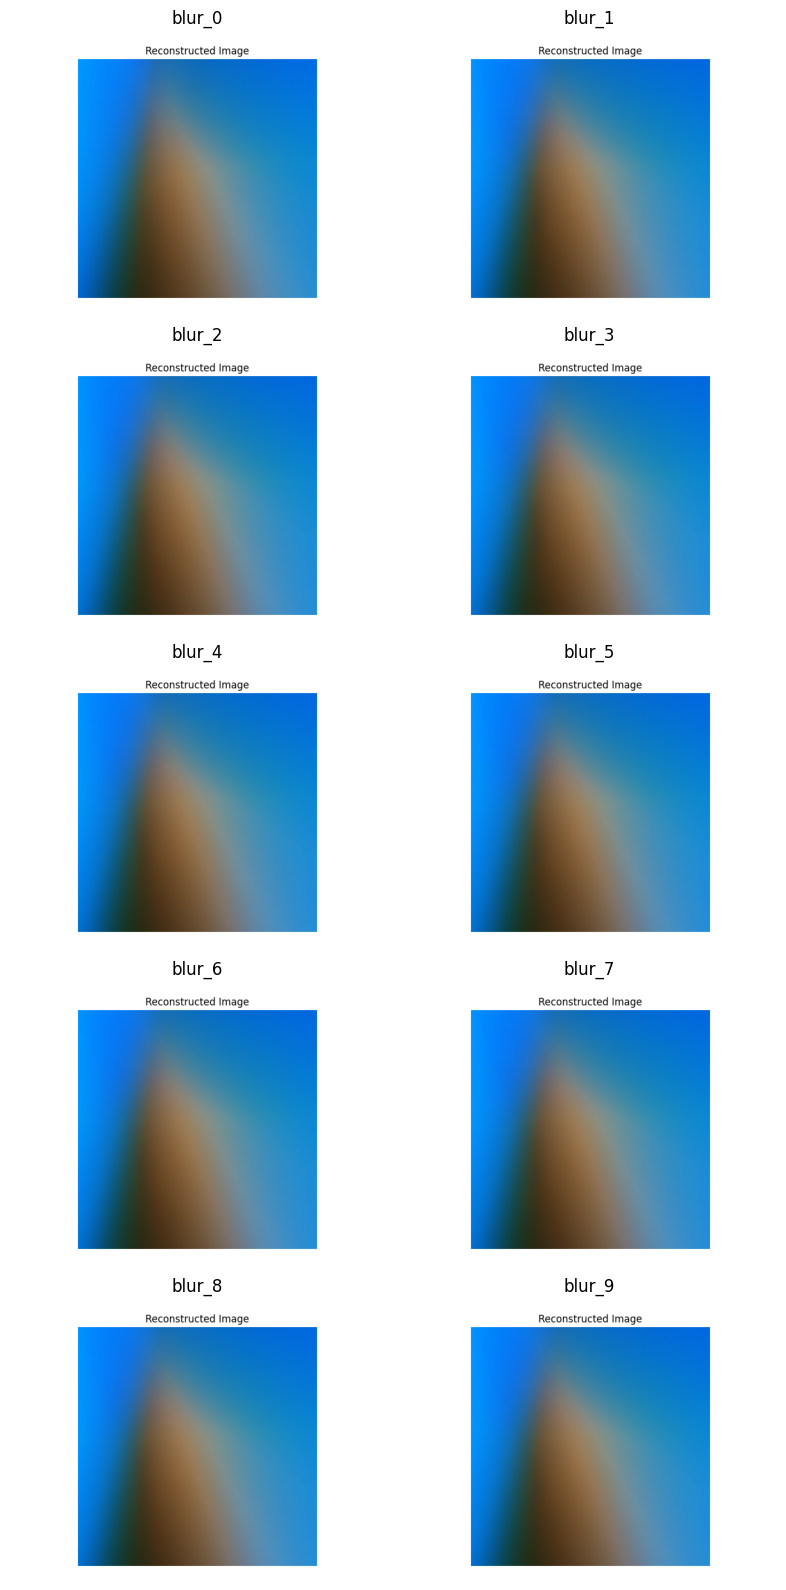

In [62]:
# Visualize
ROWS = 5
COLS = 2
TOTAL_IMAGES = ROWS * COLS

# Create a figure and a set of subplots
# figsize is in inches (width, height)
fig, axes = plt.subplots(ROWS, COLS, figsize=(8, 16))

# --- Plotting Loop ---
for i in range(TOTAL_IMAGES):
    # Construct the filename for each image
    filename = f"Q2/2.5/cat_raw/blur_{i}/epoch_final.png"
    
    # Calculate the row and column for the current subplot
    row = i // COLS
    col = i % COLS
    
    # Select the correct subplot
    ax = axes[row, col]
    
    try:
        # Read the image file
        img = mpimg.imread(filename)
        
        # Display the image on the subplot
        ax.imshow(img)
        
        # Set the title for the subplot
        ax.set_title(f'blur_{i}')
        
    except FileNotFoundError:
        # Handle cases where an image file might be missing
        ax.text(0.5, 0.5, f'Image not found:\n{filename}', 
                horizontalalignment='center', 
                verticalalignment='center',
                transform=ax.transAxes)
        print(f"Warning: Could not find the file '{filename}'")

    # Turn off the axis ticks and labels for a cleaner look
    ax.axis('off')

# Adjust layout to prevent titles and images from overlapping
plt.tight_layout()

# Display the final plot
plt.show()

### 2) Fourier Expansion

In [32]:
num_blur = 10
blurred_cat_fourier_losses = {}
freq = 5
target_pixels = cat.reshape(-1, 3) 

print(f"\n--- Training with Fourier features of frequency {freq} ---")

for i in range(num_blur):
    print(f"\nTraining on blurred image {i+1}/{num_blur}")
    cat_image_path = os.path.join("Dataset/Q2/blurred", f"blur_{i}.png")
    cat_features_fourier = Modular_Dataloader(cat_image_path, method="Fourier", freq=freq, image_type="RGB")
    cat_model_fourier = create_map_model(input_dim=cat_features_fourier.shape[1], output_dim=3, loss_type="mse")

    start_time = time.time()
    blurred_cat_fourier_losses[i] = train_model(
        model=cat_model_fourier,
        X=cat_features_fourier.T,
        Y=target_pixels.T,
        dir="Q2/2.5/cat_fourier/blur_" + str(i),
        C=3,
        epochs=100,
        batch_size=8192,
        lr=4,
        grad_accum_steps=1,
        early_stop_patience=10,
        relative_thresh=0.01,
        features=cat_features_fourier.T
    )
    end_time = time.time()

    print(f"Training time: {end_time - start_time:.2f} seconds")


--- Training with Fourier features of frequency 5 ---

Training on blurred image 1/10
Original size of Dataset/Q2/blurred/blur_0.png: (256, 256)
Shape of Fourier features: (65536, 21)
Total parameters in the model: 26627


Training:  37%|███▋      | 37/100 [00:35<01:00,  1.04epoch/s, loss=0.0106]



Early stopping triggered at epoch 37
Training completed. Results saved in Q2/2.5/cat_fourier/blur_0
Training time: 35.63 seconds

Training on blurred image 2/10
Original size of Dataset/Q2/blurred/blur_1.png: (256, 256)
Shape of Fourier features: (65536, 21)
Total parameters in the model: 26627


Training:  47%|████▋     | 47/100 [00:36<00:41,  1.29epoch/s, loss=0.0097]



Early stopping triggered at epoch 47
Training completed. Results saved in Q2/2.5/cat_fourier/blur_1
Training time: 36.56 seconds

Training on blurred image 3/10
Original size of Dataset/Q2/blurred/blur_2.png: (256, 256)
Shape of Fourier features: (65536, 21)
Total parameters in the model: 26627


Training:  35%|███▌      | 35/100 [00:24<00:46,  1.41epoch/s, loss=0.0110]



Early stopping triggered at epoch 35
Training completed. Results saved in Q2/2.5/cat_fourier/blur_2
Training time: 25.02 seconds

Training on blurred image 4/10
Original size of Dataset/Q2/blurred/blur_3.png: (256, 256)
Shape of Fourier features: (65536, 21)
Total parameters in the model: 26627


Training:  47%|████▋     | 47/100 [00:36<00:41,  1.28epoch/s, loss=0.0098]



Early stopping triggered at epoch 47
Training completed. Results saved in Q2/2.5/cat_fourier/blur_3
Training time: 36.78 seconds

Training on blurred image 5/10
Original size of Dataset/Q2/blurred/blur_4.png: (256, 256)
Shape of Fourier features: (65536, 21)
Total parameters in the model: 26627


Training:  35%|███▌      | 35/100 [00:26<00:48,  1.33epoch/s, loss=0.0110]



Early stopping triggered at epoch 35
Training completed. Results saved in Q2/2.5/cat_fourier/blur_4
Training time: 26.41 seconds

Training on blurred image 6/10
Original size of Dataset/Q2/blurred/blur_5.png: (256, 256)
Shape of Fourier features: (65536, 21)
Total parameters in the model: 26627


Training:  47%|████▋     | 47/100 [00:32<00:36,  1.44epoch/s, loss=0.0098]



Early stopping triggered at epoch 47
Training completed. Results saved in Q2/2.5/cat_fourier/blur_5
Training time: 32.83 seconds

Training on blurred image 7/10
Original size of Dataset/Q2/blurred/blur_6.png: (256, 256)
Shape of Fourier features: (65536, 21)
Total parameters in the model: 26627


Training:  35%|███▌      | 35/100 [00:23<00:43,  1.48epoch/s, loss=0.0110]



Early stopping triggered at epoch 35
Training completed. Results saved in Q2/2.5/cat_fourier/blur_6
Training time: 23.82 seconds

Training on blurred image 8/10
Original size of Dataset/Q2/blurred/blur_7.png: (256, 256)
Shape of Fourier features: (65536, 21)
Total parameters in the model: 26627


Training:  47%|████▋     | 47/100 [00:34<00:38,  1.38epoch/s, loss=0.0098]



Early stopping triggered at epoch 47
Training completed. Results saved in Q2/2.5/cat_fourier/blur_7
Training time: 34.36 seconds

Training on blurred image 9/10
Original size of Dataset/Q2/blurred/blur_8.png: (256, 256)
Shape of Fourier features: (65536, 21)
Total parameters in the model: 26627


Training:  35%|███▌      | 35/100 [00:27<00:51,  1.26epoch/s, loss=0.0110]



Early stopping triggered at epoch 35
Training completed. Results saved in Q2/2.5/cat_fourier/blur_8
Training time: 28.01 seconds

Training on blurred image 10/10
Original size of Dataset/Q2/blurred/blur_9.png: (256, 256)
Shape of Fourier features: (65536, 21)
Total parameters in the model: 26627


Training:  47%|████▋     | 47/100 [00:35<00:39,  1.34epoch/s, loss=0.0098]


Early stopping triggered at epoch 47
Training completed. Results saved in Q2/2.5/cat_fourier/blur_9
Training time: 35.17 seconds


In [34]:
# Convert all lists in blurred_cat_fourier_losses to numpy arrays
blurred_cat_fourier_losses_np = {str(k): np.array(v) for k, v in blurred_cat_fourier_losses.items()}
np.savez("Q2/2.5/blurred_cat_fourier_losses.npz", **blurred_cat_fourier_losses_np)

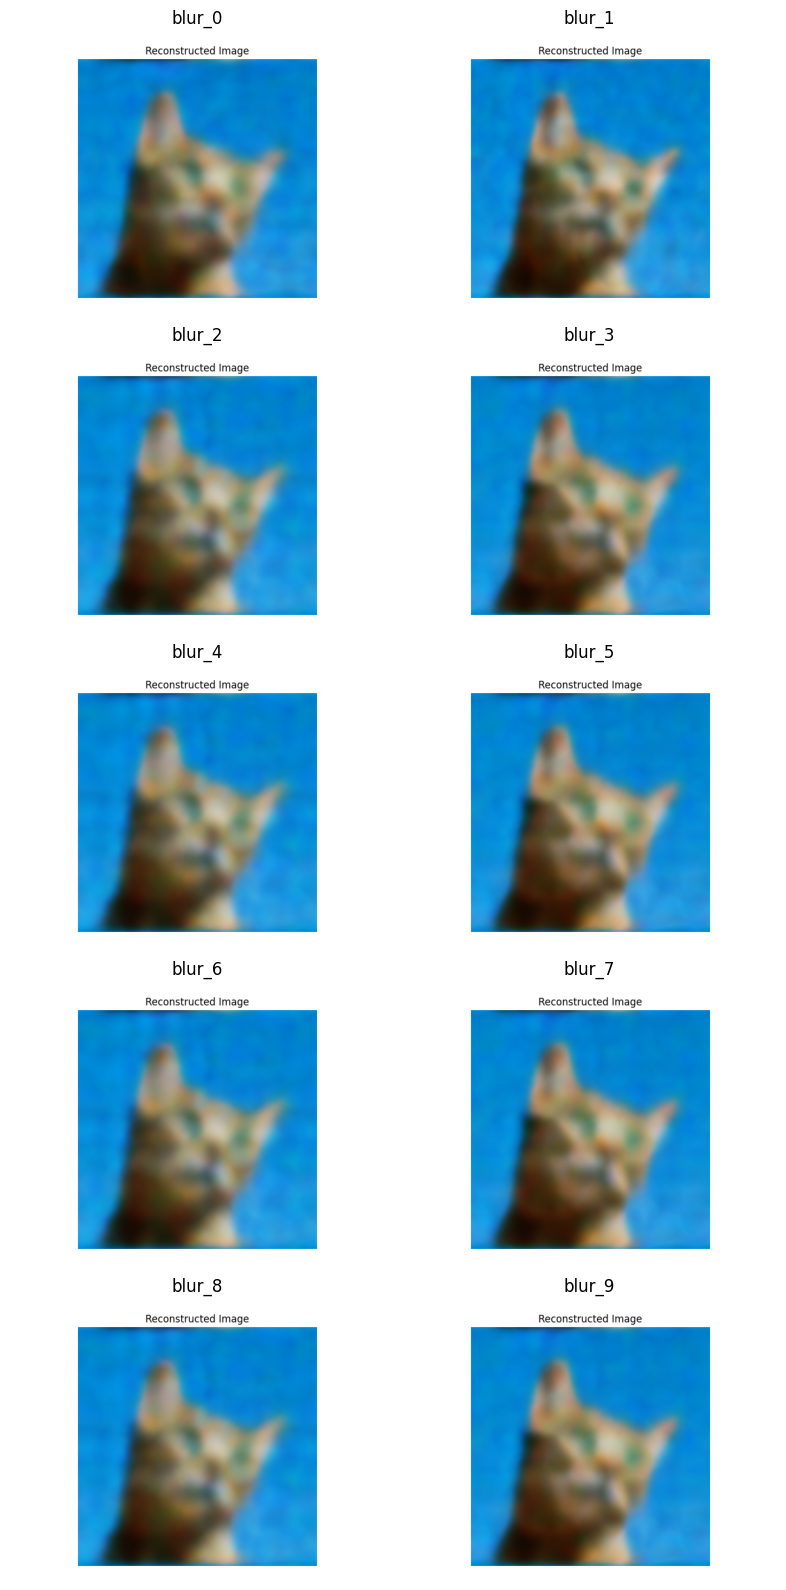

In [35]:
# Visualize
ROWS = 5
COLS = 2
TOTAL_IMAGES = ROWS * COLS

# Create a figure and a set of subplots
# figsize is in inches (width, height)
fig, axes = plt.subplots(ROWS, COLS, figsize=(8, 16))

# --- Plotting Loop ---
for i in range(TOTAL_IMAGES):
    # Construct the filename for each image
    filename = f"Q2/2.5/cat_fourier/blur_{i}/epoch_final.png"
    
    # Calculate the row and column for the current subplot
    row = i // COLS
    col = i % COLS
    
    # Select the correct subplot
    ax = axes[row, col]
    
    try:
        # Read the image file
        img = mpimg.imread(filename)
        
        # Display the image on the subplot
        ax.imshow(img)
        
        # Set the title for the subplot
        ax.set_title(f'blur_{i}')
        
    except FileNotFoundError:
        # Handle cases where an image file might be missing
        ax.text(0.5, 0.5, f'Image not found:\n{filename}', 
                horizontalalignment='center', 
                verticalalignment='center',
                transform=ax.transAxes)
        print(f"Warning: Could not find the file '{filename}'")

    # Turn off the axis ticks and labels for a cleaner look
    ax.axis('off')

# Adjust layout to prevent titles and images from overlapping
plt.tight_layout()

# Display the final plot
plt.show()

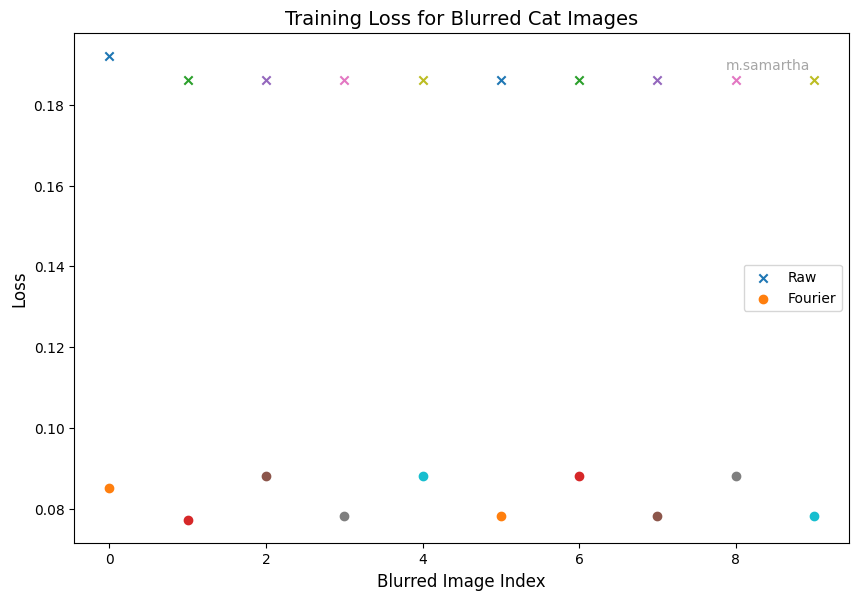

In [57]:
# Visualize losses
losses_raw = np.load("Q2/2.5/blurred_cat_raw_losses.npz")
losses_fourier = np.load("Q2/2.5/blurred_cat_fourier_losses.npz")

plt.figure(figsize=(10, 6))
for i in range(num_blur):
    plt.scatter(i, losses_raw[f"{i}"][-1], marker='x', label='Raw' if i == 0 else "")
    plt.scatter(i, losses_fourier[f"{i}"][-1], marker='o', label='Fourier' if i == 0 else "")
plt.xlabel('Blurred Image Index', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss for Blurred Cat Images', fontsize=14)
plt.legend(loc = 'center right')
plt.subplots_adjust(top=0.90, bottom=0.05)
add_username()
plt.savefig("Q2/2.5/blurred_cat_loss_comparison.png")
plt.show()
plt.close()

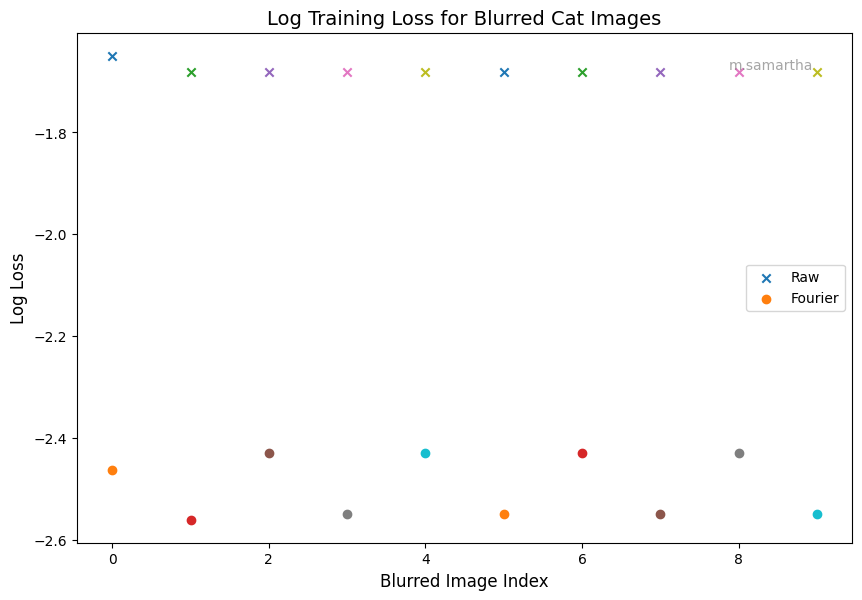

In [60]:
# Visualize losses
losses_raw = np.load("Q2/2.5/blurred_cat_raw_losses.npz")
losses_fourier = np.load("Q2/2.5/blurred_cat_fourier_losses.npz")

plt.figure(figsize=(10, 6))
for i in range(num_blur):
    plt.scatter(i, np.log(losses_raw[f"{i}"][-1]), marker='x', label='Raw' if i == 0 else "")
    plt.scatter(i, np.log(losses_fourier[f"{i}"][-1]), marker='o', label='Fourier' if i == 0 else "")
plt.xlabel('Blurred Image Index', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.title('Log Training Loss for Blurred Cat Images', fontsize=14)
plt.legend(loc = 'center right')
plt.subplots_adjust(top=0.90, bottom=0.05)
add_username()
# plt.savefig("Q2/2.5/blurred_cat_loss_comparison.png")
plt.show()
plt.close()